In [183]:
from math import radians, sin, cos, acos

slon, slat = radians(2.3522219), radians(48.856614)
elon, elat = radians(2.570289), radians(48.354976)

dist = 6371.01 * acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon))
print("The distance is %.2fkm." % dist)

def compute_earth_dist(Xo, Xa, Yo, Ya):
    [Xo, Xa, Yo, Ya] = [utils.radians(_) for _ in [Xo, Xa, Yo, Ya]]

The distance is 58.04km.


In [1101]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import utils
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans

import renyi
import utils
import sxp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
df = pd.read_csv("./data/france/pop_fr_geoloc_1975_2010.csv")

In [204]:
X = np.array([df.long.values, df.lat.values]).T
%time kmeans = MiniBatchKMeans(n_clusters=97, random_state=0).fit(X)
pp = np.zeros((len(X), kmeans.n_clusters))
pp[range(len(X)), kmeans.labels_] = 1
pops = df.pop_1975.values[:, None] / df.pop_1975.values.sum()
aa = (pp * pops).sum(0)

Wall time: 780 ms


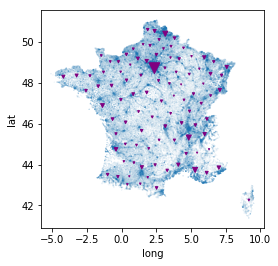

In [205]:
fig, ax = plt.subplots(figsize=(4, 4))
df.plot(ax=ax, kind="scatter", x="long", y="lat", alpha=0.7, s=df.pop_2010 / (10**5));
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='v', c='purple', s=700*aa)

torch.Size([1, 36318])

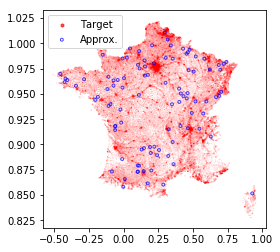

In [1677]:
alpha, d = 0.1, 2

batch_size = 40

tX = torch.tensor([X[:, 0] / 10,  X[:, 1] / 50]).transpose(0, 1)

np_fix_mu = (df.pop_1975.values[None, :] / df.pop_1975.values.sum()).squeeze()
fix_mu = torch.tensor(df.pop_1975.values[None, :] / df.pop_1975.values.sum())

mu = torch.tensor(np.array(batch_size*[1/batch_size])[None, :])

n = 97
nu = torch.tensor(np.array(n*[1/n])[None, :])
smooth_p = 0/len(tX) + np_fix_mu
smooth_p /= smooth_p.sum()
rix = np.random.choice(len(np_fix_mu), n)#, p=smooth_p)
#rix = np.random.choice(len(tX), n)
Y = torch.nn.Parameter(tX[rix, :].clone())
#Y = torch.nn.Parameter(torch.tensor(np.random.multivariate_normal(np.zeros(d), 1.1*np.eye(d), n)))

y_optimizer = torch.optim.Adam([Y], lr=1e-2, betas=(0.99, 0.99), amsgrad=True)
#y_optimizer = torch.optim.RMSprop([Y], lr=0.01)
#y_optimizer = torch.optim.SGD([Y], lr=1e-4, momentum=0.9)

optims = [y_optimizer]

kernel = lambda x, y: renyi.generic_kernel(x, y, lambda u: renyi.rbf_kernel(u, sigmas=[0.1, 0.07], p=2, d=2))
my_kernel = lambda x, y: rbf_kernel(x, y, sigmas=[0.07], p=2, d=2)

loss_list = []

plt.figure(figsize=(4, 4))
plt.scatter(tX.data.numpy()[:, 0], tX.data.numpy()[:, 1], s=list(500*fix_mu.data.squeeze().numpy()), label='Target', marker='h', c='r', alpha=0.7)
plt.scatter(Y.data.numpy()[:, 0], Y.data.numpy()[:, 1], s=list(1000*nu.data.squeeze().numpy()), label='Approx.', marker='h', facecolors='none', edgecolors='b', alpha=0.7)
plt.legend(loc='best')
plt.show();

In [1667]:
def new_mixture_divergence(mu, X, nu, Y, alpha, kernel):
    n, m = mu.shape[1], nu.shape[1]
    #print(n, m)
    K = kernel(X, Y)
    Kmu = K[:, :n] @ mu.transpose(0, 1)
    Knu = K[:, -m:] @ nu.transpose(0, 1)
#     print(Kmu.min(), Knu.min())
    
#     rat1 = Kmu[:n] / utils.min_clamp(Knu[:n], 1e-50)
#     rat2 = Knu[-m:] / utils.min_clamp(Kmu[-m:], 1e-50)
    
    rat1 = Kmu[:n] / Knu[:n]
    rat2 = Knu[-m:] / Kmu[-m:]
    
    lg_fn = torch.log
    
    if alpha == 1:
        div = (mu @ lg_fn(rat1)) + (nu @ lg_fn(rat2))
    else:
        div = (1/(alpha - 1)) * ( lg_fn(mu @ rat1**(alpha-1)) + lg_fn(nu @ rat2**(alpha-1)) )
    return div, K


def rbf_kernel(X, Y, sigmas=[1.], p=2, d=2):
	pdist = utils.batch_pdist(X, Y, p)
	res = torch.zeros_like(pdist)
	for sigma in sigmas:
		res += torch.exp(- (pdist/sigma)**d)
	return res / len(sigmas)

def non_divergence(mu, X, nu, Y, alpha, kernel):
    n, m = mu.shape[1], nu.shape[1]
    
    Kyy = kernel(Y, Y)
    Kyx = kernel(Y, X)

    Knu = Kyy @ nu.transpose(0, 1)
    Kmu = Kyx @ mu.transpose(0, 1)
    
    if alpha == 1:
        div = nu @ torch.log(Knu / Kmu)
    else:
        div =   (1/(alpha - 1)) * torch.log(nu @ (Knu / Kmu)**(alpha-1))
    
    return div, None

In [1754]:
def sim_divergence(nu, mu, K, alpha):
    
    Knu = K @ nu.transpose(0, 1)
    Kmu = K @ mu.transpose(0, 1)
    
    if alpha == 1:
        div = nu @ torch.log(Kmu / Knu)
    else:
        div =   (1/(alpha - 1)) * torch.log(nu @ ((Kmu / Knu) ** alpha))
    
    return div

In [1791]:
#n = 137
# mu = torch.tensor(np.array(n*[1/n])[None, :])

divs = []

for _ in range(10):
    
    n = np.random.randint(2, 3)
    
    Kn = 0.01*np.random.rand(n, n)
    Kn = (Kn * Kn.T) + 0.7 * np.eye(n)
    Kn = utils.from_numpy(Kn)
    
    divls = []
    
    for _ in range(100):
        mu = torch.tensor(np.random.dirichlet(n*[1/n])[None, :])
        nu = torch.tensor(np.random.dirichlet(n*[1])[None, :])
        divls.append(sim_divergence(nu, mu, Kn, alpha=0.1).item())
    
    divs.append(divls)

In [1792]:
np.array(divs).min(axis=1)

array([6.00541733e-06, 6.22680446e-07, 1.05062095e-06, 1.37935261e-05,
       6.77968618e-06, 1.29768441e-05, 3.89603635e-05, 6.48405736e-05,
       9.85509382e-09, 9.84542907e-06])

In [1816]:
n = 2
r = 1
alpha = 2
Kn = torch.tensor([[1, np.exp(-r)], [np.exp(-r), 1]])

theta = 0.1
rho = 0.5

p = torch.tensor([[theta, 1-theta]])
q = torch.tensor([[rho, 1-rho]]) 

In [1817]:
T, R = np.meshgrid(np.linspace(0, 1, 10), np.linspace(0, 1, 10))
Z = np.zeros_like(T)
W = np.zeros_like(T)
U = np.zeros_like(T)

In [1822]:
for i in range(10):
    for j in range(10):
        theta = T[i, j]
        rho = R[i, j]
        p = torch.tensor([[theta, 1-theta]])
        q = torch.tensor([[rho, 1-rho]]) 
        
        Z[i, j] = sim_divergence(q, p, Kn, alpha)
        W[i, j] = sim_divergence(p, q, Kn, alpha)
        U[i, j] = Z[i, j] - W[i, j]
        
U.min()

-1.3555671963840723

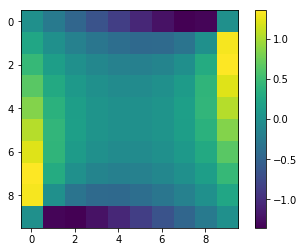

In [1823]:
plt.imshow(U)
plt.colorbar()

tensor([[0.1281]])

In [1642]:
rix = np.random.choice(len(np_fix_mu), batch_size, p=np_fix_mu)
cX = tX[rix]

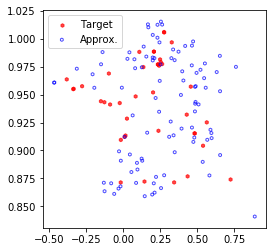

In [1643]:
plt.figure(figsize=(4, 4))
plt.scatter(cX.data.numpy()[:, 0], cX.data.numpy()[:, 1], s=list(500*mu.data.squeeze().numpy()), label='Target', marker='h', c='r', alpha=0.7)
plt.scatter(Y.data.numpy()[:, 0], Y.data.numpy()[:, 1], s=list(1000*nu.data.squeeze().numpy()), label='Approx.', marker='h', facecolors='none', edgecolors='b', alpha=0.7)
plt.legend(loc='best')
plt.show();

In [1638]:
Knu = Kxy @ nu.transpose(0, 1)
Kmu = Kxy.transpose(0, 1) @ mu.transpose(0, 1)

In [1636]:
for bla in range(10):
    [_.zero_grad() for _ in optims]

    Kxy = my_kernel(cX, Y)

    loss = (1 / (1-alpha)) * ( torch.log(mu @ (Kxy @ nu.transpose(0, 1))**(alpha-1)) +  torch.log(nu @ (Kxy.transpose(0, 1) @ mu.transpose(0, 1))**(alpha-1)))
    #print(loss.item())

    loss.backward()
    [_.step() for _ in optims];

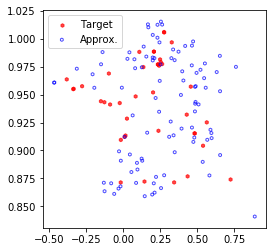

In [1644]:
plt.figure(figsize=(4, 4))
plt.scatter(cX.data.numpy()[:, 0], cX.data.numpy()[:, 1], s=list(500*mu.data.squeeze().numpy()), label='Target', marker='h', c='r', alpha=0.7)
plt.scatter(Y.data.numpy()[:, 0], Y.data.numpy()[:, 1], s=list(1000*nu.data.squeeze().numpy()), label='Approx.', marker='h', facecolors='none', edgecolors='b', alpha=0.7)
plt.legend(loc='best')
plt.show();

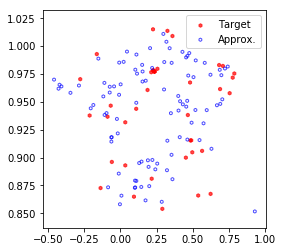

0 : 0.4069


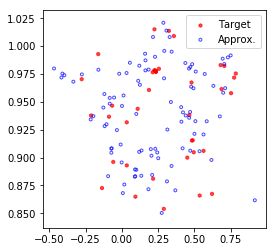

0 : 0.0738
0 : 0.0607
0 : 0.0442
0 : 0.0381


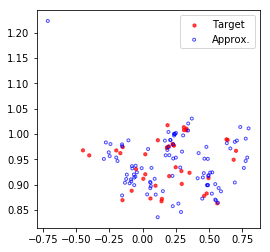

0 : 0.2524


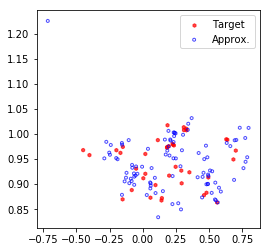

0 : 0.1643
0 : 0.1318
0 : 0.1013
0 : 0.0683


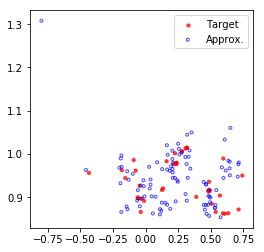

0 : 0.2650


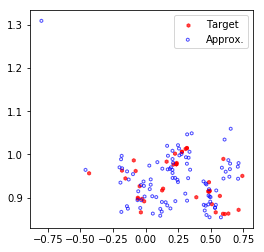

0 : 0.1364
0 : 0.0675
0 : 0.0812
0 : 0.0915


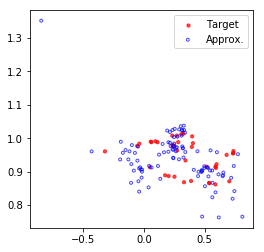

0 : 0.4609


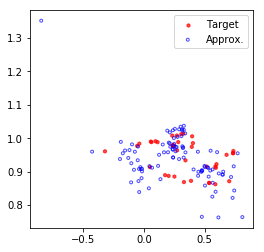

0 : 0.2923
0 : 0.1533
0 : 0.1290
0 : 0.1312


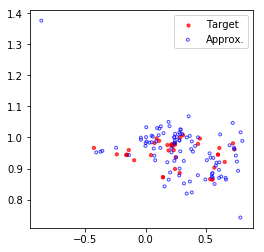

0 : 0.3423


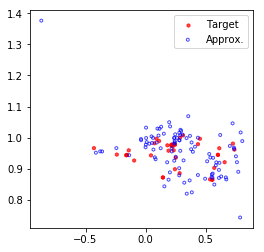

0 : 0.2136
0 : 0.1469
0 : 0.1558
0 : 0.1557


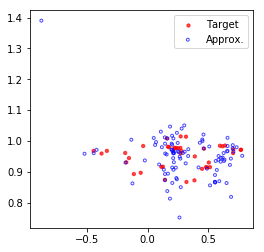

0 : 0.3345


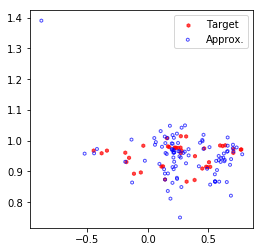

0 : 0.2250
0 : 0.1161
0 : 0.1005
0 : 0.1404


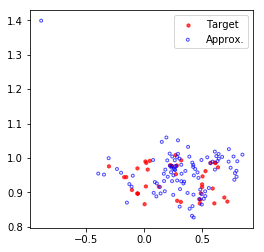

0 : 0.5414


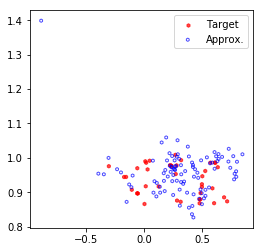

0 : 0.3817
0 : 0.1939
0 : 0.1354
0 : 0.1500


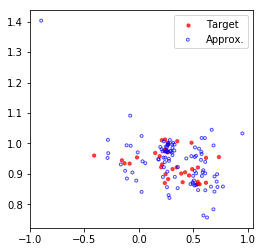

0 : 0.3106


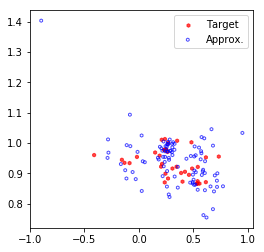

0 : 0.2430
0 : 0.1869
0 : 0.1815
0 : 0.1598


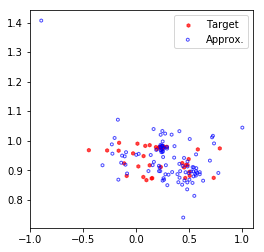

0 : 0.4020


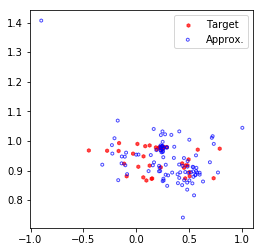

0 : 0.3416
0 : 0.2258
0 : 0.1793
0 : 0.1531


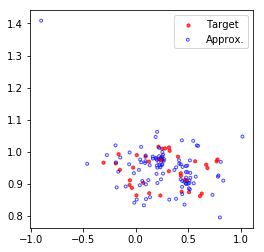

0 : 0.2851


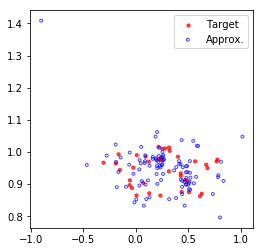

0 : 0.1791
0 : 0.1116
0 : 0.1365
0 : 0.1524


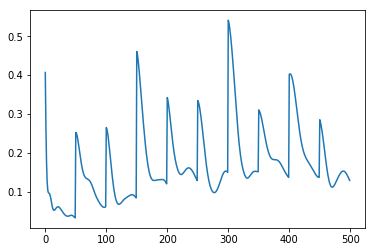

In [1678]:
for epnum in range(10):
    
    rix = np.random.choice(len(np_fix_mu), batch_size, p=np_fix_mu)
    cX = tX[rix]
    
    
    plt.figure(figsize=(4, 4))
    plt.scatter(cX.data.numpy()[:, 0], cX.data.numpy()[:, 1], s=list(500*mu.data.squeeze().numpy()), label='Target', marker='h', c='r', alpha=0.7)
    plt.scatter(Y.data.numpy()[:, 0], Y.data.numpy()[:, 1], s=list(1000*nu.data.squeeze().numpy()), label='Approx.', marker='h', facecolors='none', edgecolors='b', alpha=0.7)
    plt.legend(loc='best')
    plt.show();

    for in_loop in range(50):
        
        [_.zero_grad() for _ in optims]
        loss, K = new_mixture_divergence(mu, cX, nu, Y, alpha, kernel)
        #loss, K = non_divergence(mu, cX, nu, Y, alpha, kernel)
        #loss, K = non_divergence(nu, Y, mu, cX, alpha, kernel)
        
        loss.backward()
        [_.step() for _ in optims]
        loss_list.append(loss.item())
        if in_loop % 10 == 0:
            print("%d : %.4f" % (_, loss.item()))
            
        if in_loop % 250 == 0:
            plt.figure(figsize=(4, 4))
            plt.scatter(cX.data.numpy()[:, 0], cX.data.numpy()[:, 1], s=list(500*mu.data.squeeze().numpy()), label='Target', marker='h', c='r', alpha=0.7)
            plt.scatter(Y.data.numpy()[:, 0], Y.data.numpy()[:, 1], s=list(1000*nu.data.squeeze().numpy()), label='Approx.', marker='h', facecolors='none', edgecolors='b', alpha=0.7)
            plt.legend(loc='best')
            plt.show();
        
plt.plot(loss_list)

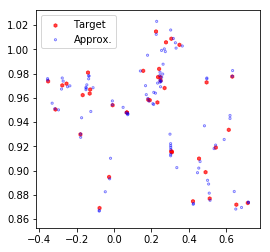

In [1672]:
plt.figure(figsize=(4, 4))
plt.scatter(cX.data.numpy()[:, 0], cX.data.numpy()[:, 1], s=list(500*mu.data.squeeze().numpy()), label='Target', marker='h', c='r', alpha=0.7)
plt.scatter(Y.data.numpy()[:, 0], Y.data.numpy()[:, 1], s=list(500*nu.data.squeeze().numpy()), label='Approx.', marker='h', facecolors='none', edgecolors='b', alpha=0.5)
plt.legend(loc='best')
plt.show();

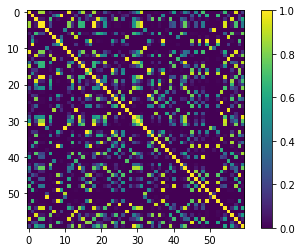

In [1406]:
plt.imshow(K.data)
plt.colorbar()

In [1085]:
rix = cat1.sample(sample_shape=[batch_size]).squeeze()
cX = tX[rix]
%time loss, K = new_mixture_divergence(mu, cX, nu, Y, alpha, kernel)
print(loss)

tensor(1.9779e-05, dtype=torch.float64, grad_fn=<MinBackward1>) tensor(8.4820e-07, dtype=torch.float64, grad_fn=<MinBackward1>)
Wall time: 1.99 ms
tensor([[16.0032]], dtype=torch.float64, grad_fn=<MulBackward0>)


In [1070]:
n, m = mu.shape[1], nu.shape[1]
print(n, m)
K = kernel(cX, Y)
Kmu = K[:, :n] @ mu.transpose(0, 1)
Knu = K[:, -m:] @ nu.transpose(0, 1)
div = (1/(alpha - 1)) * ( torch.log(mu @ (Kmu[:n] / Knu[:n])**(alpha-1)) + torch.log(nu @ (Knu[-m:] / Kmu[-m:])**(alpha-1)) )

10 20


In [621]:
mu @ (Kmu[:n] / Knu[:n]), nu @ (Knu[-m:] / Knu[-m:])

(tensor([[0.9988]], dtype=torch.float64, grad_fn=<MmBackward>),
 tensor([[1.0000]], dtype=torch.float64, grad_fn=<MmBackward>))

In [569]:
mu @ (Kmu[:n] / Knu[:n])

tensor([[1.1125]], dtype=torch.float64, grad_fn=<MmBackward>)

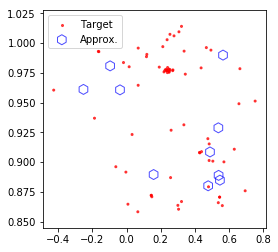

In [768]:
plt.figure(figsize=(4, 4))
plt.scatter(cX.data.numpy()[:, 0], cX.data.numpy()[:, 1], s=list(500*bprob.data.squeeze().numpy()), label='Target', marker='h', c='r', alpha=0.7)
plt.scatter(Y.data.numpy()[:, 0], Y.data.numpy()[:, 1], s=list(1000*nu.data.squeeze().numpy()), label='Approx.', marker='h', facecolors='none', edgecolors='b', alpha=0.7)
plt.legend(loc='best')
plt.show();

In [911]:
# fig, ax = plt.subplots(figsize=(4, 4))
# df.plot(ax=ax, kind="scatter", x="long", y="lat", alpha=0.7, s=df.pop_2010 / (10**5));
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='v', c='purple', s=700*aa)
# plt.scatter(sampleX[:, 0], sampleX[:, 1], s=10, c='r')